In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['figure.autolayout'] = True

In [8]:
df = pd.read_excel(
    "analisis_kinerja.xlsx", 
    sheet_name="analisa_kinerja", 
    skiprows=1
)

In [9]:
df.head()

,customer_name,product_id,product_name,actual_price,discount_percentage,persentase_gross_laba,nett_sales,nett_profit,rating_transaksi,rating_cabang,transaction_date,year,branch_name,provinsi,kota
0,Derrick Wright III,KF116,"Psycholeptics drugs, Hypnotics and sedatives d...",251700,0.10,0.2,226530.0,45306.0,3,3.988631,2021-08-25,2021,Kimia Farma - Klinik & Apotek,DI Yogyakarta,Yogyakarta
1,Elizabeth Ramos,KF116,"Psycholeptics drugs, Hypnotics and sedatives d...",251700,0.12,0.2,221496.0,44299.2,3,4.001535,2020-12-29,2020,Kimia Farma - Klinik-Apotek-Laboratorium,Riau,Pekanbaru
2,Meghan Warner,KF116,"Psycholeptics drugs, Hypnotics and sedatives d...",251700,0.09,0.2,229047.0,45809.4,3,4.012968,2020-02-03,2020,Kimia Farma - Apotek,Jawa Tengah,Cilacap
3,Steven Roberts,KF116,"Psycholeptics drugs, Hypnotics and sedatives d...",251700,0.10,0.2,226530.0,45306.0,3,4.048303,2022-09-09,2022,Kimia Farma - Klinik & Apotek,Jawa Barat,Subang
4,Linda Bruce DDS,KF116,"Psycholeptics drugs, Hypnotics and sedatives d...",251700,0.07,0.2,234081.0,46816.2,3,3.995765,2020-06-20,2020,Kimia Farma - Klinik-Apotek-Laboratorium,Jawa Barat,Sukabumi


In [10]:
df.columns = (
    df.columns.astype(str)
    .str.strip()
    .str.replace(r"\s+", "_", regex=True)
    .str.replace(r"[^0-9a-zA-Z_]", "", regex=True)
    .str.lower()
)

In [11]:
num_cols = [
    "actual_price",
    "discount_percentage",
    "persentase_gross_laba",
    "nett_sales",
    "nett_profit",
    "rating_transaksi",
    "rating_cabang",
    "year",
]
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

if "transaction_date" in df.columns:
    df["transaction_date"] = pd.to_datetime(df["transaction_date"], errors="coerce")

In [12]:
if "discount_percentage" in df.columns:
    if (df["discount_percentage"].dropna() > 1).any():
        df["discount_pct_01"] = df["discount_percentage"] / 100.0
    else:
        df["discount_pct_01"] = df["discount_percentage"]

In [13]:
pd.set_option("display.max_columns", 100)
print("Shape:", df.shape)
print("\nKolom:", list(df.columns))

Shape: (500, 16)

Kolom: ['customer_name', 'product_id', 'product_name', 'actual_price', 'discount_percentage', 'persentase_gross_laba', 'nett_sales', 'nett_profit', 'rating_transaksi', 'rating_cabang', 'transaction_date', 'year', 'branch_name', 'provinsi', 'kota', 'discount_pct_01']


In [14]:
mv = df.isna().mean().sort_values(ascending=False).to_frame("missing_ratio")
display(mv.head(20))

,missing_ratio
customer_name,0.0
product_id,0.0
product_name,0.0
actual_price,0.0
discount_percentage,0.0
persentase_gross_laba,0.0
nett_sales,0.0
nett_profit,0.0
rating_transaksi,0.0
rating_cabang,0.0


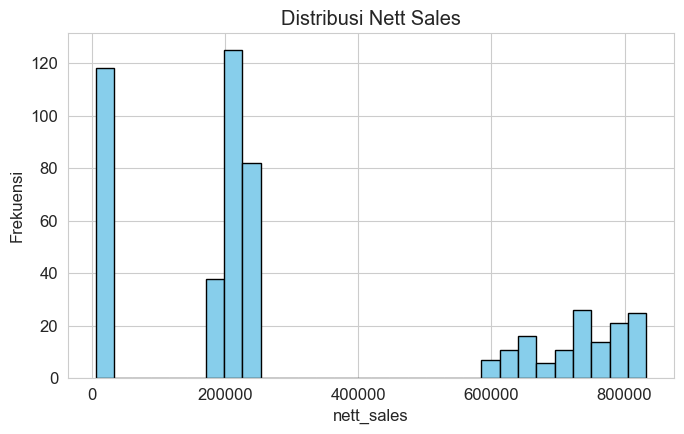

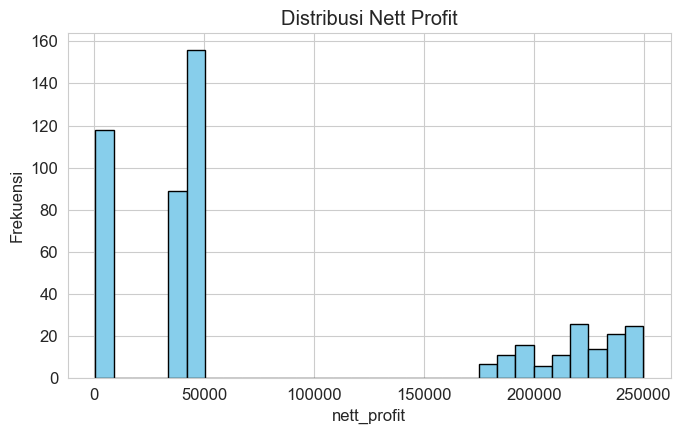

In [29]:
def hist_plot(series, title=None, bins=30):
    s = pd.to_numeric(series, errors='coerce').dropna()
    if s.empty:
        print(f"Tidak ada data untuk {title if title else series.name}")
        return
    
    plt.figure(figsize=(7, 4.5))
    plt.hist(s, bins=bins, color='skyblue', edgecolor='black')
    
    # Judul
    if title:
        plt.title(title)
    else:
        plt.title(f"Distribusi {series.name if series.name else ''}")
    
    # Label sumbu
    plt.xlabel(series.name if series.name else "Nilai")
    plt.ylabel("Frekuensi")
    
    # Layout rapih
    plt.tight_layout()
    plt.show()

hist_plot(df['nett_sales'], title="Distribusi Nett Sales")
hist_plot(df['nett_profit'], title="Distribusi Nett Profit")


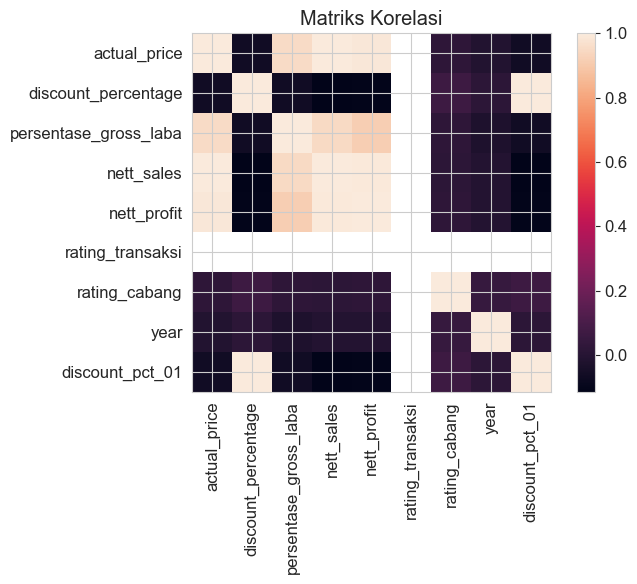

In [25]:
num = df.select_dtypes(include="number")
if num.shape[1] >= 2:
    corr = num.corr(numeric_only=True)
    plt.figure(figsize=(8,6))
    im = plt.imshow(corr, interpolation="nearest")
    plt.title("Matriks Korelasi")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.tight_layout()
    plt.show()

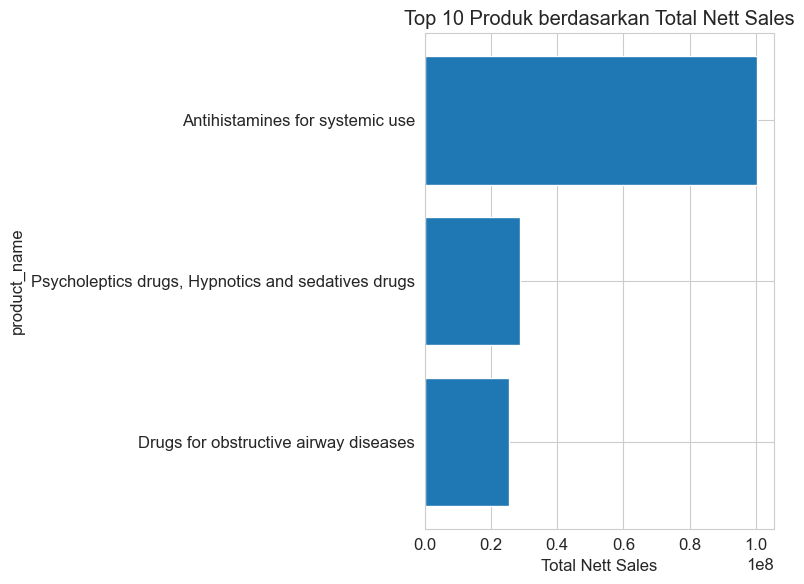

In [17]:
if {"product_name", "nett_sales"}.issubset(df.columns):
    top_prod = (df.groupby("product_name", dropna=False)["nett_sales"]
                  .sum(min_count=1)
                  .sort_values(ascending=False)
                  .head(10)
                  .sort_values(ascending=True))
    if not top_prod.empty:
        plt.figure(figsize=(8,6))
        plt.barh(top_prod.index.astype(str), top_prod.values)
        plt.title("Top 10 Produk berdasarkan Total Nett Sales")
        plt.xlabel("Total Nett Sales")
        plt.ylabel("product_name")
        plt.tight_layout()
        plt.show()

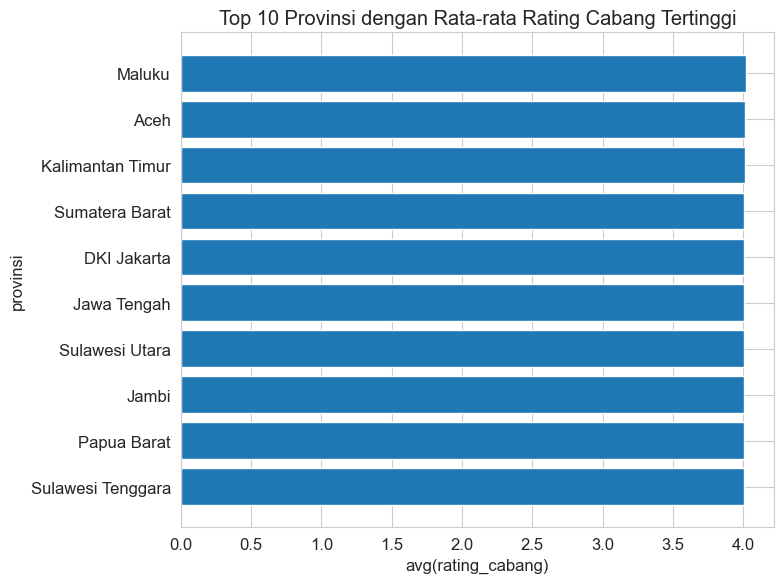

In [18]:
if {"provinsi", "rating_cabang"}.issubset(df.columns):
    avg_rating = (df.groupby("provinsi", dropna=False)["rating_cabang"]
                    .mean()
                    .sort_values(ascending=False)
                    .head(10)
                    .sort_values(ascending=True))
    if not avg_rating.empty:
        plt.figure(figsize=(8,6))
        plt.barh(avg_rating.index.astype(str), avg_rating.values)
        plt.title("Top 10 Provinsi dengan Rata-rata Rating Cabang Tertinggi")
        plt.xlabel("avg(rating_cabang)")
        plt.ylabel("provinsi")
        plt.tight_layout()
        plt.show()

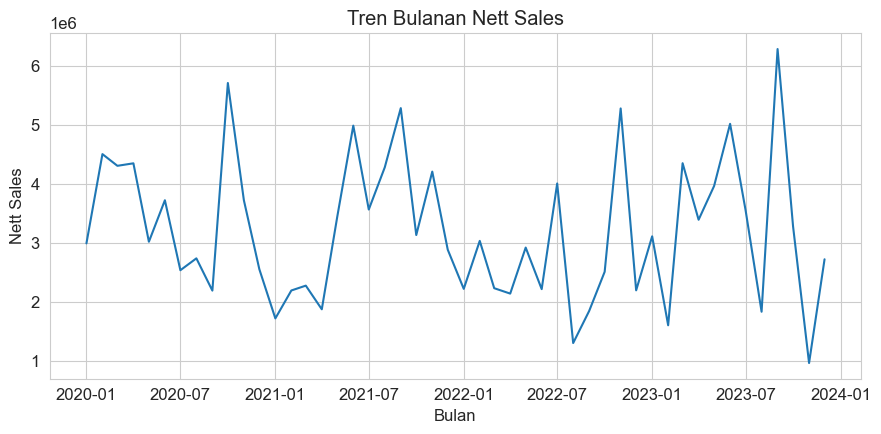

In [19]:
if {"transaction_date", "nett_sales"}.issubset(df.columns):
    ts = df[["transaction_date", "nett_sales"]].dropna()
    if not ts.empty:
        ts = ts.set_index("transaction_date").sort_index()
        m = ts["nett_sales"].resample("MS").sum(min_count=1)
        if not m.dropna().empty:
            plt.figure(figsize=(9,4.5))
            plt.plot(m.index, m.values)
            plt.title("Tren Bulanan Nett Sales")
            plt.xlabel("Bulan")
            plt.ylabel("Nett Sales")
            plt.tight_layout()
            plt.show()

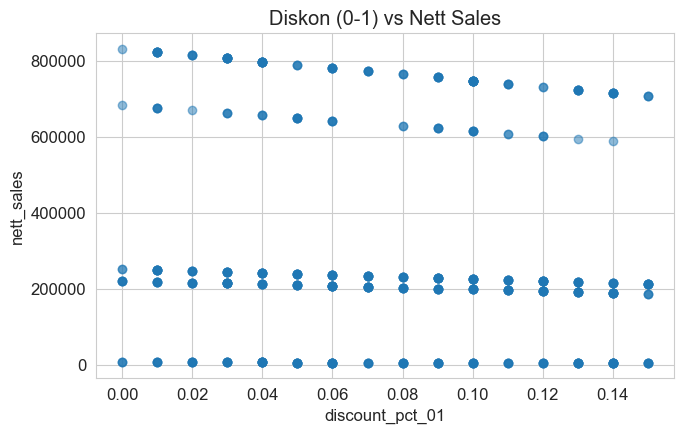

In [20]:
if {"discount_pct_01", "nett_sales"}.issubset(df.columns):
    x = df["discount_pct_01"].astype(float)
    y = df["nett_sales"].astype(float)
    mask = x.notna() & y.notna()
    if mask.sum() > 2:
        plt.figure(figsize=(7,4.5))
        plt.scatter(x[mask], y[mask], alpha=0.5)
        plt.title("Diskon (0-1) vs Nett Sales")
        plt.xlabel("discount_pct_01")
        plt.ylabel("nett_sales")
        plt.tight_layout()
        plt.show()

<Figure size 1000x600 with 0 Axes>

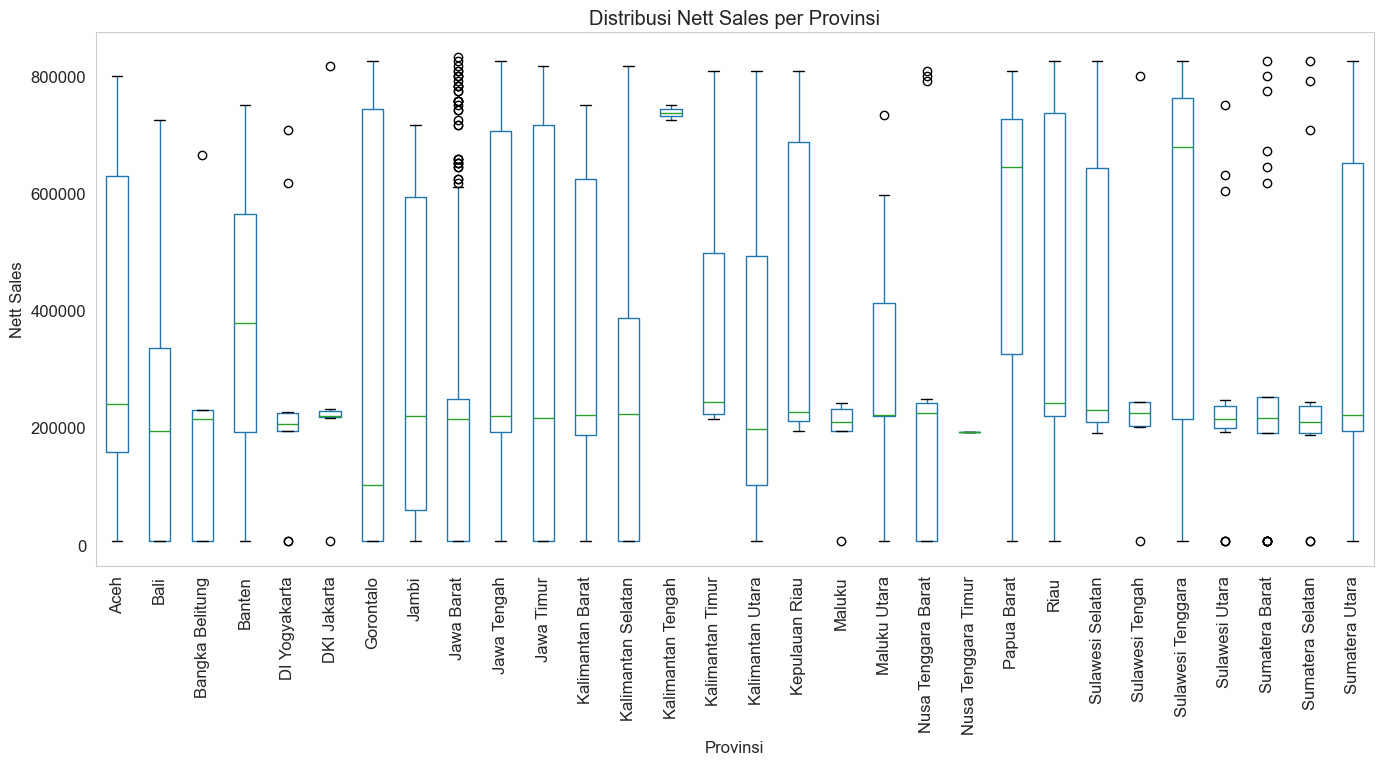

In [21]:
if {"provinsi", "nett_sales"}.issubset(df.columns):
    plt.figure(figsize=(10,6))
    df_box = df.dropna(subset=["provinsi", "nett_sales"])
    df_box = df_box[df_box["nett_sales"] > 0]  # filter agar tidak ada nilai nol/negatif
    df_box.boxplot(column="nett_sales", by="provinsi", grid=False, rot=90)
    plt.title("Distribusi Nett Sales per Provinsi")
    plt.suptitle("")  # hilangkan judul bawaan pandas
    plt.xlabel("Provinsi")
    plt.ylabel("Nett Sales")
    plt.tight_layout()
    plt.show()

/var/folders/rn/03j08vpj73xckw5gq14ybzzc0000gn/T/ipykernel_69998/4242526407.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(pareto_df["product_name"], rotation=90)


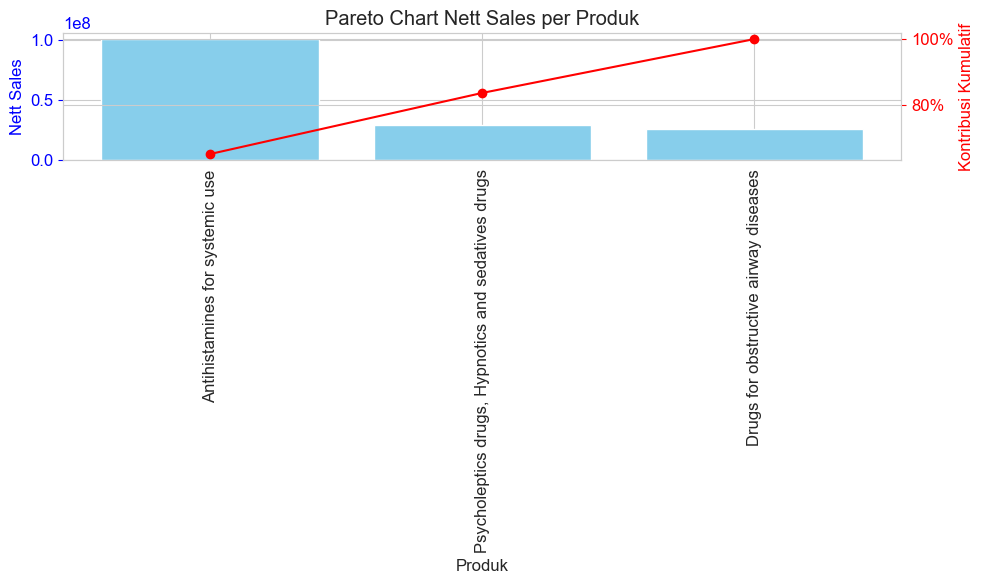

In [22]:
if {"product_name", "nett_sales"}.issubset(df.columns):
    pareto_df = (
        df.groupby("product_name", dropna=False)["nett_sales"]
          .sum()
          .sort_values(ascending=False)
          .reset_index()
    )
    pareto_df["cum_pct"] = pareto_df["nett_sales"].cumsum() / pareto_df["nett_sales"].sum() * 100

    fig, ax1 = plt.subplots(figsize=(10,6))
    ax1.bar(pareto_df["product_name"], pareto_df["nett_sales"], color="skyblue")
    ax1.set_xlabel("Produk")
    ax1.set_ylabel("Nett Sales", color="blue")
    ax1.tick_params("y", colors="blue")
    ax1.set_xticklabels(pareto_df["product_name"], rotation=90)

    ax2 = ax1.twinx()
    ax2.plot(pareto_df["product_name"], pareto_df["cum_pct"], color="red", marker="o")
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}%'))
    ax2.set_ylabel("Kontribusi Kumulatif", color="red")
    ax2.tick_params("y", colors="red")

    plt.title("Pareto Chart Nett Sales per Produk")
    plt.tight_layout()
    plt.show()